# ADASYN 모델로 데이터 증폭 후 분석

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn.datasets as d
import sklearn.model_selection as ms
import sklearn.metrics as mt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import pydot  #graphviz의 dot language 와의 인터페이스를 제공하는 패키지 임포트
from IPython.display import Image #IPython의 display와 관련된 Pulbic API
import pydotplus
import graphviz

# 글씨체 보이기
plt.rcParams['font.family'] = 'AppleGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
# 데이터 불러오기
data = '/Users/yimdohyun/Desktop/문서/대학교/3학년/2학기/산공/DM/팀프로젝트/팀프로젝트_데이터/departure_data.xlsx'
df = pd.read_excel(data)

### 데이터 초기화용

In [3]:
copy = df

In [3]:
# 취소 데이터 확인하기
df.loc[(df['현황'] == '취소') & (df['사유'] == '태풍'), '현황'] = '기상 취소'
cancel_rows = df[df['현황'] == '취소']
reason_counts = cancel_rows['사유'].value_counts()

# 지연 데이터 확인하기
delay_rows = df[df['현황'] == '지연']
reason_counts = cancel_rows['사유'].value_counts()

df['최저운고'].fillna(0, inplace=True)
df['강수량(mm)'].fillna(0, inplace=True)
df['현황'].fillna('출발', inplace=True)

# 기상 취소, 기상 지연의 이유가 아닌 행들을 삭제하는 코드
# 취소에 사유가 없는 열 삭제
df = df[(df['현황'] != '취소')]
# 지연에 사유가 없는 열 삭제
df = df[(df['현황'] != '지연') | (df['사유'].notna())]
# 회항, 기상회항 삭제
df = df[(df['현황'] != '회항')]
df = df[(df['현황'] != '기상 회항')]

# 사용할 칼럼들을 추출 (기상 요건들과 운송 현황)
selected = ['온도','시정', '전운량', '최저운고','풍속', '강수량(mm)', '현황']
sdf = df[selected]
sdf

,온도,시정,전운량,최저운고,풍속,강수량(mm),현황
0,0.2,450,2,30.0,2,0.0,출발
1,0.2,450,2,30.0,2,0.0,출발
2,0.2,450,2,30.0,2,0.0,출발
3,0.2,450,2,30.0,2,0.0,출발
4,0.2,450,2,30.0,2,0.0,출발
...,...,...,...,...,...,...,...
585021,-4.1,1000,8,30.0,3,0.0,출발
585022,-4.1,1000,8,30.0,3,0.0,출발
585023,-4.1,1000,8,30.0,3,0.0,출발
585024,-4.1,1000,8,30.0,3,0.0,출발


### 증폭 전 데이터 분포 시각화 하기

/var/folders/k5/qbv0ktcn6tz9gp8kw0h9s4900000gn/T/ipykernel_37746/3821288424.py:3: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('/Users/yimdohyun/Desktop/문서/대학교/3학년/2학기/산공/DM/팀프로젝트/보고서/최종/시각자료/증폭 전 데이터 분포.png')
/Users/yimdohyun/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


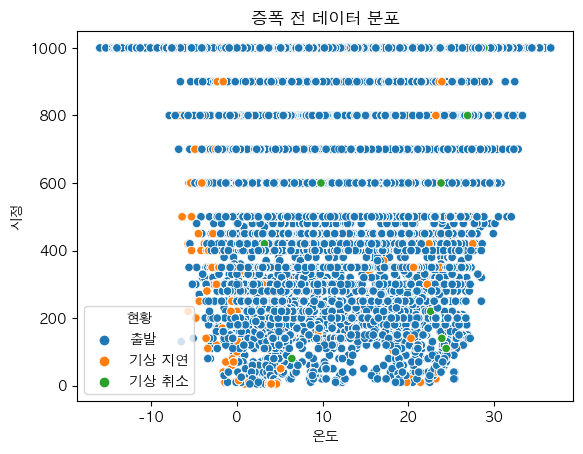

In [7]:
sns.scatterplot(data=sdf, x=sdf.iloc[:, 0], y=sdf.iloc[:, 1], hue='현황')
plt.title("증폭 전 데이터 분포")
plt.savefig('/Users/yimdohyun/Desktop/문서/대학교/3학년/2학기/산공/DM/팀프로젝트/보고서/최종/시각자료/증폭 전 데이터 분포.png')

# 원본 데이터 ADASYN 증폭

In [4]:
# '현황' 기준으로 클래스 분포 확인
class_counts = sdf['현황'].value_counts()
print("기존 라벨 분포도:")
print(class_counts)

X = sdf[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
y = sdf['현황']
# ADASYN 적용
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=42)
X_ada, y_ada = adasyn.fit_resample(X, y)

# 증강된 데이터프레임 생성
org_resampled = pd.DataFrame(X_ada, columns=X.columns)
org_resampled['현황'] = y_ada

# 증강된 클래스 분포 확인
resampled_class_counts = org_resampled['현황'].value_counts()
print("\nResampled Class Distribution:")
print(resampled_class_counts)

기존 라벨 분포도:
출발       532733
기상 지연      4918
기상 취소       473
Name: 현황, dtype: int64

Resampled Class Distribution:
기상 지연    532873
출발       532733
기상 취소    532603
Name: 현황, dtype: int64


In [5]:
org_resampled

,온도,시정,전운량,최저운고,풍속,강수량(mm),현황
0,0.200000,450,2,30.000000,2,0.0,출발
1,0.200000,450,2,30.000000,2,0.0,출발
2,0.200000,450,2,30.000000,2,0.0,출발
3,0.200000,450,2,30.000000,2,0.0,출발
4,0.200000,450,2,30.000000,2,0.0,출발
...,...,...,...,...,...,...,...
1598204,15.895382,800,5,35.119859,6,0.0,기상 취소
1598205,12.268370,800,7,35.058574,8,0.0,기상 취소
1598206,11.832929,800,7,35.864945,8,0.0,기상 취소
1598207,16.436804,800,7,31.580291,9,0.0,기상 취소


## 원본 Decision Tree 

In [9]:
X = org_resampled[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
y = org_resampled['현황']
#test, training (7:3 분할)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 100)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1118746, 6) (479463, 6) (1118746,) (479463,)


### 하이퍼 파라미터 튜닝

In [11]:
from sklearn.model_selection import GridSearchCV

#테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
dt_clf = DecisionTreeClassifier(random_state = 33)
parameters = {'max_depth': [10, 15, 20, 25, 30, 35, 40, 45, 50],
              'min_samples_split': [2,4,8,16, 32, 64, 128, 256, 512],
              'splitter': ['best', 'random']}

grid_dt = GridSearchCV(dt_clf, # estimator 객체,
                      param_grid = parameters, cv = 5
                      # n_jobs = -1: 모든 cpu를 사용)
                      )

grid_dt.fit(X_test, y_test)

result = pd.DataFrame(grid_dt.cv_results_['params'])
result['mean_test_score'] = grid_dt.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

,max_depth,min_samples_split,splitter,mean_test_score
108,40,2,best,0.957140
126,45,2,best,0.957112
144,50,2,best,0.957046
90,35,2,best,0.957044
145,50,2,random,0.956912
...,...,...,...,...
3,10,4,random,0.643545
9,10,32,random,0.643167
11,10,64,random,0.642529
13,10,128,random,0.642135


In [12]:
best_params = {'max_depth' : 40, 'min_samples_split': 2, 'splitter': 'best'}

#최적 파라미터 조합으로 DecisionTreeClassifier 초기화
best_dt = DecisionTreeClassifier(**best_params)

#최적모델로 학습
best_dt.fit(X_test, y_test)

DecisionTreeClassifier(max_depth=40)

In [13]:
#학습결과평가
from sklearn.metrics import classification_report
best_dt.fit(X_test, y_test)
predict_dt = best_dt.predict(X_test)
print(classification_report(y_test, predict_dt, zero_division=0))
accuracy = accuracy_score(y_test, predict_dt)
print("Accuracy of Decision Tree: ", accuracy)

              precision    recall  f1-score   support

       기상 지연       0.97      0.98      0.98    159984
       기상 취소       0.98      1.00      0.99    159854
          출발       1.00      0.97      0.98    159625

    accuracy                           0.98    479463
   macro avg       0.98      0.98      0.98    479463
weighted avg       0.98      0.98      0.98    479463

Accuracy of Decision Tree:  0.9838485972848792


In [13]:
#교차검증
from sklearn.model_selection import cross_val_score, cross_validate

#각 폴드의 스코어
scores = cross_val_score(best_dt, X, y, cv = 5)
scores

pd.DataFrame(cross_validate(best_dt, X, y, cv = 5))
print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.6393794597237509


## Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as mt

In [21]:
#test, training (7:3 분할)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 100)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X = org_resampled[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
y = org_resampled['현황']
#test, training (7:3 분할)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 100)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(376686, 6) (161438, 6) (376686,) (161438,)
(1118746, 6) (479463, 6) (1118746,) (479463,)


### RF 하이퍼 파라미터 튜닝

In [ ]:
#하이퍼 파라미터 튜닝(그리드 서치)4

from sklearn.model_selection import GridSearchCV

#테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
rf6 = RandomForestClassifier(random_state=0)

parameters = {'n_estimators': [120, 130, 140, 150],
              'max_depth': [30, 40, 50, 60, 70],
              'min_samples_split': [4, 8]}

grid_rf4 = GridSearchCV(rf6, # estimator 객체,
                      param_grid = parameters, cv = 5
                      # n_jobs = -1: 모든 cpu를 사용)
                      )

grid_rf4.fit(X_train, y_train)

result = pd.DataFrame(grid_rf4.cv_results_['params'])
result['mean_test_score'] = grid_rf4.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

In [ ]:
best_params_rf = grid_rf4.best_params_  
print("Best Parameters for Random Forest:", best_params_rf)

#최적 파라미터 조합으로 RandomForestClassifier 초기화
best_rf = RandomForestClassifier(**best_params_rf)

#최적모델로 학습
best_rf.fit(X_train, y_train)

# 최적 모델 평가
predict3 = best_rf.predict(X_test)
print("Accuracy of the Best Random Forest model:", accuracy_score(y_test,predict3)) 

In [ ]:
# #교차검증: 검증데이터셋 나눠서 평가하기 (데이터셋: training, test, validation 으로 나눔)

from sklearn.model_selection import cross_validate

# 여러 평가 지표를 지정
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# cross_validate를 사용하여 교차 검증 수행
cv_results = cross_validate(best_rf, X, y, cv=5, scoring=scoring)

# 결과 출력
result_df = pd.DataFrame({
    'Accuracy': cv_results['test_accuracy'],
    'Precision': cv_results['test_precision_macro'],
    'Recall': cv_results['test_recall_macro'],
    'F1': cv_results['test_f1_macro']
})

# 교차검증 평균 출력
print('교차검증 평균 - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(
    result_df['Accuracy'].mean(),
    result_df['Precision'].mean(),
    result_df['Recall'].mean(),
    result_df['F1'].mean()
))


In [ ]:
#학습결과평가
from sklearn.metrics import classification_report
best_rf.fit(X_test, y_test)
predict_rf = best_rf.predict(X_test)
print(classification_report(y_test, predict_rf, zero_division=0))
accuracy = accuracy_score(y_test, predict_rf)
print("Accuracy of Random Forest: ", accuracy)

## Multinoomial Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import itertools

In [61]:
# 테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
mlr = LogisticRegression(random_state=42, multi_class='multinomial', solver='saga')
parameters = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1','l2']}

X = sdf_resampled[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
y = sdf_resampled['현황']

# 테스트와 훈련 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# 데이터 스케일 조정
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_mlr = GridSearchCV(mlr, param_grid=parameters, cv=5)
grid_mlr.fit(X_train_scaled, y_train)

# 결과를 DataFrame으로 표시
result = pd.DataFrame(grid_mlr.cv_results_['params'])
result['mean_test_score'] = grid_mlr.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False, inplace=True)

# 결과 출력
print("Best Hyperparameters:", grid_mlr.best_params_)
print("GridSearchCV Results:\n", result)

/Users/yimdohyun/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimdohyun/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimdohyun/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimdohyun/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimdohyun/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Hyperparameters: {'C': 0.001, 'penalty': 'l1'}
GridSearchCV Results:
         C penalty  mean_test_score
0   0.001      l1         0.554015
1   0.001      l2         0.553844
2   0.010      l1         0.553781
3   0.010      l2         0.553756
4   0.100      l1         0.553755
7   1.000      l2         0.553749
9  10.000      l2         0.553749
8  10.000      l1         0.553748
6   1.000      l1         0.553745
5   0.100      l2         0.553745


In [62]:
# 최적의 하이퍼파라미터로 모델 생성
best_mlr = LogisticRegression(random_state=42, multi_class='multinomial', solver='saga', max_iter = 1000, C=0.001, penalty='l1')
best_mlr.fit(X_train_scaled, y_train)

LogisticRegression(C=0.001, max_iter=1000, multi_class='multinomial',
                   penalty='l1', random_state=42, solver='saga')

In [63]:
# 학습 결과 평가
from sklearn.metrics import classification_report, accuracy_score

best_mlr.fit(X_test_scaled, y_test)
predict_mlr = best_mlr.predict(X_test_scaled)
print(classification_report(y_test, predict_mlr, zero_division=0))
accuracy = accuracy_score(y_test, predict_mlr)
print("Accuracy of Multinomial Logistic Regression: ", accuracy)

              precision    recall  f1-score   support

       기상 지연       0.58      0.56      0.57    159984
       기상 취소       0.54      0.63      0.58    159854
          출발       0.55      0.47      0.51    159625

    accuracy                           0.55    479463
   macro avg       0.55      0.55      0.55    479463
weighted avg       0.55      0.55      0.55    479463

Accuracy of Multinomial Logistic Regression:  0.5537090453277937


In [65]:
#교차검증
from sklearn.model_selection import cross_val_score, cross_validate

#각 폴드의 스코어
scores = cross_val_score(best_mlr, X, y, cv = 5)
scores

pd.DataFrame(cross_validate(best_mlr, X, y, cv = 5))
print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.5188388476445036


# 20,000개로 ADASYN 기법으로 증폭하여 분석하기

In [6]:
# 데이터프레임에서 "출발"인 값을 가진 행을 추출
departure_data = sdf[sdf['현황'] == "출발"]

# 랜덤하게 20,000개 추출
random_selected_data = departure_data.sample(n=20000, random_state=42)

# 지연 데이터 와 취소 데이터 추출하기
delay_data = sdf[sdf['현황'] == "기상 지연"]
cancel_data = sdf[sdf['현황'] == '기상 취소']

new = [random_selected_data, delay_data, cancel_data]

# 데이터프레임들을 수직 방향으로 합치기
sdf = pd.concat(new, axis=0, ignore_index=True)
sdf
print(sdf['현황'].value_counts())

출발       20000
기상 지연     4918
기상 취소      473
Name: 현황, dtype: int64


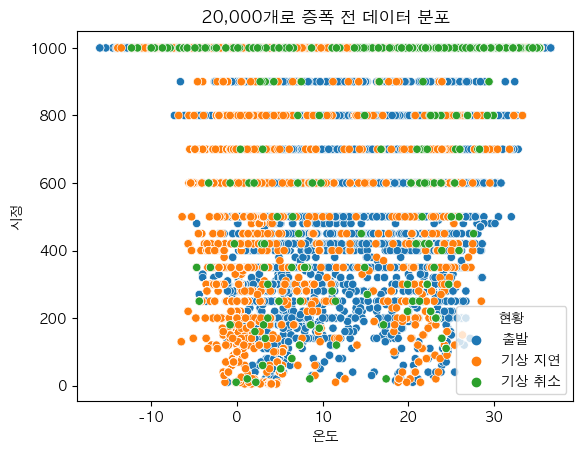

In [9]:
sns.scatterplot(data=sdf, x=sdf.iloc[:, 0], y=sdf.iloc[:, 1], hue='현황')
plt.title("20,000개로 증폭 전 데이터 분포")
plt.savefig('/Users/yimdohyun/Desktop/문서/대학교/3학년/2학기/산공/DM/팀프로젝트/보고서/최종/시각자료/20,000개로 증폭 전 데이터 분포.png')

In [7]:
# '현황' 기준으로 클래스 분포 확인
class_counts = sdf['현황'].value_counts()
print("기존 라벨 분포도:")
print(class_counts)

X = sdf[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
y = sdf['현황']

# ADASYN 적용
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy='auto', random_state = 42)
X_ada, y_ada = adasyn.fit_resample(X, y)

# 증강된 데이터프레임 생성
sdf_resampled = pd.DataFrame(X_ada, columns=X.columns)
sdf_resampled['현황'] = y_ada

# 증강된 클래스 분포 확인
resampled_class_counts = sdf_resampled['현황'].value_counts()
print("\nResampled Class Distribution:")
print(resampled_class_counts)

기존 라벨 분포도:
출발       20000
기상 지연     4918
기상 취소      473
Name: 현황, dtype: int64

Resampled Class Distribution:
출발       20000
기상 지연    19966
기상 취소    19929
Name: 현황, dtype: int64


In [8]:
sdf_resampled

,온도,시정,전운량,최저운고,풍속,강수량(mm),현황
0,13.100000,1000,7,120.000000,7,0.0,출발
1,14.000000,350,2,20.000000,7,0.0,출발
2,28.400000,1000,8,10.000000,10,0.0,출발
3,17.200000,1000,4,40.000000,16,0.0,출발
4,-4.000000,1000,0,0.000000,10,0.0,출발
...,...,...,...,...,...,...,...
59890,22.995933,800,3,40.000000,9,0.0,기상 취소
59891,10.913459,800,7,38.981815,8,0.0,기상 취소
59892,14.990896,800,5,35.821011,6,0.0,기상 취소
59893,22.515222,800,4,40.000000,9,0.0,기상 취소


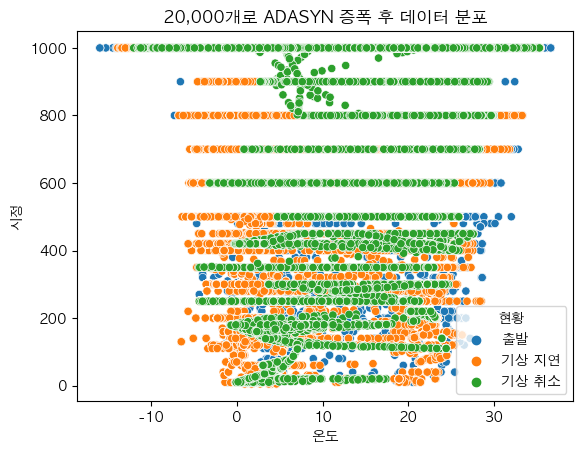

In [8]:
sns.scatterplot(data=sdf_resampled, x=sdf_resampled.iloc[:, 0], y=sdf_resampled.iloc[:, 1], hue='현황')
plt.title("20,000개로 ADASYN 증폭 후 데이터 분포")
plt.savefig('/Users/yimdohyun/Desktop/문서/대학교/3학년/2학기/산공/DM/팀프로젝트/보고서/최종/시각자료/20,000개로 ADASYN 증폭 데이터 분포.png')

## Decision Tree

In [10]:
X = sdf_resampled[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
y = sdf_resampled['현황']
#test, training (7:3 분할)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 100)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(41926, 6) (17969, 6) (41926,) (17969,)


In [49]:
from sklearn.model_selection import GridSearchCV

#테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
dt_clf = DecisionTreeClassifier(random_state = 33)
parameters = {'max_depth': [10, 15, 20, 25, 30],
              'min_samples_split': [2,4,8,16, 32, 64, 128, 256, 512],
              'splitter': ['best', 'random']}

grid_dt = GridSearchCV(dt_clf, # estimator 객체,
                      param_grid = parameters, cv = 5
                      # n_jobs = -1: 모든 cpu를 사용)
                      )

grid_dt.fit(X_test, y_test)

result = pd.DataFrame(grid_dt.cv_results_['params'])
result['mean_test_score'] = grid_dt.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

,max_depth,min_samples_split,splitter,mean_test_score
54,25,2,best,0.748567
73,30,2,random,0.747954
72,30,2,best,0.745673
55,25,2,random,0.743335
36,20,2,best,0.742223
...,...,...,...,...
17,10,512,random,0.560521
35,15,512,random,0.558963
71,25,512,random,0.558629
53,20,512,random,0.558629


In [11]:
best_params = {'max_depth' : 25, 'min_samples_split': 2, 'splitter': 'best'}

#최적 파라미터 조합으로 DecisionTreeClassifier 초기화
best_dt = DecisionTreeClassifier(**best_params)

#최적모델로 학습
best_dt.fit(X_test, y_test)

DecisionTreeClassifier(max_depth=25)

In [12]:
#학습결과평가
from sklearn.metrics import classification_report
best_dt.fit(X_test, y_test)
predict_dt = best_dt.predict(X_test)
print(classification_report(y_test, predict_dt, zero_division=0))
accuracy = accuracy_score(y_test, predict_dt)
print("Accuracy of Decision Tree: ", accuracy)

              precision    recall  f1-score   support

       기상 지연       0.97      0.98      0.98      5913
       기상 취소       0.98      0.99      0.99      6043
          출발       0.99      0.96      0.98      6013

    accuracy                           0.98     17969
   macro avg       0.98      0.98      0.98     17969
weighted avg       0.98      0.98      0.98     17969

Accuracy of Decision Tree:  0.9795202849351661


In [13]:
#교차검증
from sklearn.model_selection import cross_val_score, cross_validate

#각 폴드의 스코어
scores = cross_val_score(best_dt, X, y, cv = 5)
scores

pd.DataFrame(cross_validate(best_dt, X, y, cv = 5))
print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.6739627681776442


In [15]:
# Feature Importance 얻기
importances = best_dt.feature_importances_

# 결과를 저장할 리스트 초기화
feature_importance_list = []

# 결과 출력
for feature, importance in zip(X_train.columns, importances):
    print(f"{feature}: {importance}")
    feature_importance_list.append((feature, importance))

# 중요도를 기준으로 내림차순 정렬
sorted_feature_importance_desc = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

# 결과 출력
print("----------------------------------------------------")
print("Sorted Feature Importance (Descending):")
for feature, importance in sorted_feature_importance_desc:
    print(f"{feature}: {importance:.2f}")

온도: 0.41722416737041873
시정: 0.10657464609639027
전운량: 0.08936180796647064
최저운고: 0.15900591377028608
풍속: 0.1882645107497854
강수량(mm): 0.03956895404664893
----------------------------------------------------
Sorted Feature Importance (Descending):
온도: 0.42
풍속: 0.19
최저운고: 0.16
시정: 0.11
전운량: 0.09
강수량(mm): 0.04


## Random Forest

In [11]:
X = sdf_resampled[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
y = sdf_resampled['현황']

#test, training (7:3 분할)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 100)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(41926, 6) (17969, 6) (41926,) (17969,)


In [13]:
#하이퍼 파라미터 튜닝(그리드 서치)4

from sklearn.model_selection import GridSearchCV

#테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
rf6 = RandomForestClassifier(random_state=0)

parameters = {'n_estimators': [120, 130, 140, 150],
              'max_depth': [30, 40, 50, 60, 70],
              'min_samples_split': [4, 8]}

grid_rf4 = GridSearchCV(rf6, # estimator 객체,
                      param_grid = parameters, cv = 5
                      # n_jobs = -1: 모든 cpu를 사용)
                      )

grid_rf4.fit(X_train, y_train)

result = pd.DataFrame(grid_rf4.cv_results_['params'])
result['mean_test_score'] = grid_rf4.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False)

,max_depth,min_samples_split,n_estimators,mean_test_score
1,30,4,130,0.855316
3,30,4,150,0.855173
2,30,4,140,0.855126
24,60,4,120,0.855078
32,70,4,120,0.855078
8,40,4,120,0.855078
16,50,4,120,0.855078
25,60,4,130,0.855054
17,50,4,130,0.855054
33,70,4,130,0.855054


In [14]:
best_params_rf = grid_rf4.best_params_  
print("Best Parameters for Random Forest:", best_params_rf)

#최적 파라미터 조합으로 RandomForestClassifier 초기화
best_rf = RandomForestClassifier(**best_params_rf)

#최적모델로 학습
best_rf.fit(X_train, y_train)

# 최적 모델 평가
predict3 = best_rf.predict(X_test)
print("Accuracy of the Best Random Forest model:", accuracy_score(y_test,predict3)) 

Best Parameters for Random Forest: {'max_depth': 30, 'min_samples_split': 4, 'n_estimators': 130}
Accuracy of the Best Random Forest model: 0.8615949691134732


In [15]:
# #교차검증: 검증데이터셋 나눠서 평가하기 (데이터셋: training, test, validation 으로 나눔)

from sklearn.model_selection import cross_validate

# 여러 평가 지표를 지정
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# cross_validate를 사용하여 교차 검증 수행
cv_results = cross_validate(best_rf, X, y, cv=5, scoring=scoring)

# 결과 출력
result_df = pd.DataFrame({
    'Accuracy': cv_results['test_accuracy'],
    'Precision': cv_results['test_precision_macro'],
    'Recall': cv_results['test_recall_macro'],
    'F1': cv_results['test_f1_macro']
})

# 교차검증 평균 출력
print('교차검증 평균 - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(
    result_df['Accuracy'].mean(),
    result_df['Precision'].mean(),
    result_df['Recall'].mean(),
    result_df['F1'].mean()
))


교차검증 평균 - Accuracy: 0.6957, Precision: 0.7160, Recall: 0.6955, F1: 0.6918


In [16]:
#학습결과평가
from sklearn.metrics import classification_report
best_rf.fit(X_test, y_test)
predict_rf = best_rf.predict(X_test)
print(classification_report(y_test, predict_rf, zero_division=0))
accuracy = accuracy_score(y_test, predict_rf)
print("Accuracy of Random Forest: ", accuracy)

              precision    recall  f1-score   support

       기상 지연       0.96      0.96      0.96      5913
       기상 취소       0.97      0.99      0.98      6043
          출발       0.97      0.95      0.96      6013

    accuracy                           0.97     17969
   macro avg       0.97      0.97      0.97     17969
weighted avg       0.97      0.97      0.97     17969

Accuracy of Random Forest:  0.9677221882130336


## Multinomial Logistic Regrssion

In [66]:
# 테스트하고자 하는 파라미터 값들을 사전 타입으로 정의
mlr = LogisticRegression(random_state=42, multi_class='multinomial', solver='saga')
parameters = {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1','l2']}

X = sdf_resampled[["온도", '시정', '전운량', '최저운고', '풍속', '강수량(mm)']]
y = sdf_resampled['현황']

# 테스트와 훈련 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# 데이터 스케일 조정
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_mlr = GridSearchCV(mlr, param_grid=parameters, cv=5)
grid_mlr.fit(X_train_scaled, y_train)

# 결과를 DataFrame으로 표시
result = pd.DataFrame(grid_mlr.cv_results_['params'])
result['mean_test_score'] = grid_mlr.cv_results_['mean_test_score']
result.sort_values(by='mean_test_score', ascending=False, inplace=True)

# 결과 출력
print("Best Hyperparameters:", grid_mlr.best_params_)
print("GridSearchCV Results:\n", result)

/Users/yimdohyun/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimdohyun/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimdohyun/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimdohyun/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimdohyun/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Hyperparameters: {'C': 0.001, 'penalty': 'l1'}
GridSearchCV Results:
         C penalty  mean_test_score
0   0.001      l1         0.554015
1   0.001      l2         0.553844
2   0.010      l1         0.553781
3   0.010      l2         0.553756
4   0.100      l1         0.553755
7   1.000      l2         0.553749
9  10.000      l2         0.553749
8  10.000      l1         0.553748
6   1.000      l1         0.553745
5   0.100      l2         0.553745


In [67]:
# 최적의 하이퍼파라미터로 모델 생성
best_mlr = LogisticRegression(random_state=42, multi_class='multinomial', solver='saga', max_iter = 1000, C=0.001, penalty='l1')
best_mlr.fit(X_train_scaled, y_train)

LogisticRegression(C=0.001, max_iter=1000, multi_class='multinomial',
                   penalty='l1', random_state=42, solver='saga')

In [68]:
# 학습 결과 평가
from sklearn.metrics import classification_report, accuracy_score

best_mlr.fit(X_test_scaled, y_test)
predict_mlr = best_mlr.predict(X_test_scaled)
print(classification_report(y_test, predict_mlr, zero_division=0))
accuracy = accuracy_score(y_test, predict_mlr)
print("Accuracy of Multinomial Logistic Regression: ", accuracy)

              precision    recall  f1-score   support

       기상 지연       0.58      0.56      0.57    159984
       기상 취소       0.54      0.63      0.58    159854
          출발       0.55      0.47      0.51    159625

    accuracy                           0.55    479463
   macro avg       0.55      0.55      0.55    479463
weighted avg       0.55      0.55      0.55    479463

Accuracy of Multinomial Logistic Regression:  0.5537090453277937


In [69]:
#교차검증
from sklearn.model_selection import cross_val_score, cross_validate

#각 폴드의 스코어
scores = cross_val_score(best_mlr, X, y, cv = 5)
scores

pd.DataFrame(cross_validate(best_mlr, X, y, cv = 5))
print('교차검증 평균: ', scores.mean())

KeyboardInterrupt: 